In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import torch
import cebra
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from evaluate_interpretability2 import *
embedding_sizes = [8, 16, 32, 64]
rats = ['achilles', 'buddy', 'cicero', 'gatsby']
topk_values = [8, 16, 32]
expansion_factor = 8
lr = 1e-3
fixed_l1 = "0.0001"
root_model_dir = "../sae_gridsearch_2_fixed"
embedding_root = "../final_embeddings"
data_root = "../data"

all_results = []

def compute_interpretability_scores(latent, behavior, neural):

    beh_corr = compute_behavior_corr(latent, behavior)
    nl_corr = neuron_latent_attribution(neural, latent)
    behavior_score = compute_score(beh_corr, k = 3)
    neuron_score = compute_score(nl_corr, k =10)

    return behavior_score, neuron_score

for rat in rats:
    ds = cebra.datasets.hippocampus.SingleRatDataset(name=rat, root=data_root, download=True)
    labels = ds.continuous_index.numpy()
    split_idx = int(0.8 * len(ds.neural))

    position_train = labels[:split_idx, 0]
    position_valid = labels[split_idx:, 0]
    direction_train = np.argmax(labels[:split_idx, 1:], axis=1)
    direction_valid = np.argmax(labels[split_idx:, 1:], axis=1)
    behavior_train = np.stack([position_train, direction_train == 1, direction_train == 0], axis=1)

    neural_train = ds.neural[:split_idx].numpy()
    neural_valid = ds.neural[split_idx:].numpy()

    for dim in embedding_sizes:
        emb_path = f"{embedding_root}/output_dimension_{dim}_{rat}"
        z_train = np.load(f"{emb_path}/train_embeddings.npy")
        z_valid = np.load(f"{emb_path}/valid_embeddings.npy")

        r2_train = compute_position_r2(z_train, position_train)
        r2_valid = compute_position_r2(z_valid, position_valid)
        acc_train = compute_direction_acc(z_train, direction_train)
        acc_valid = compute_direction_acc(z_valid, direction_valid)
        behavior_score, neuron_score = compute_interpretability_scores(z_train, behavior_train, neural_train)

        all_results.append({
            "rat": rat, "dim": dim, "topk": None, "model": "cebra",
            "r2_train": r2_train, "r2_valid": r2_valid,
            "acc_train": acc_train, "acc_valid": acc_valid,
            "behavior_score": behavior_score, "neuron_score": neuron_score,
            "sparsity": compute_sparsity(z_train)
        })

        for topk in topk_values:
            print(f"{rat}-{dim}-topk{topk}")
            try:
                z_sae_train = get_topk_latents_by_params(
                    name=rat, dim=dim, embedding_array=z_train, topk=topk,
                    expansion_factor=expansion_factor, lr=lr,
                    fixed_l1=fixed_l1, root_model_dir=root_model_dir
                )
                z_sae_valid = get_topk_latents_by_params(
                    name=rat, dim=dim, embedding_array=z_valid, topk=topk,
                    expansion_factor=expansion_factor, lr=lr,
                    fixed_l1=fixed_l1, root_model_dir=root_model_dir
                )

                r2_train_sae = compute_position_r2(z_sae_train, position_train)
                r2_valid_sae = compute_position_r2(z_sae_valid, position_valid)
                acc_train_sae = compute_direction_acc(z_sae_train, direction_train)
                acc_valid_sae = compute_direction_acc(z_sae_valid, direction_valid)
                behavior_score_sae, neuron_score_sae = compute_interpretability_scores(z_sae_train, behavior_train, neural_train)

                all_results.append({
                    "rat": rat, "dim": dim, "topk": topk, "model": "sae_topk",
                    "r2_train": r2_train_sae, "r2_valid": r2_valid_sae,
                    "acc_train": acc_train_sae, "acc_valid": acc_valid_sae,
                    "behavior_score": behavior_score_sae, "neuron_score": neuron_score_sae,
                    "sparsity": compute_sparsity(z_sae_train)
                })
            except Exception as e:
                print(f"Skipping {rat}-{dim}-topk{topk}: {e}")

df_results = pd.DataFrame(all_results)

achilles-8-topk8
achilles-8-topk16
achilles-8-topk32
achilles-16-topk8
achilles-16-topk16
achilles-16-topk32
achilles-32-topk8
achilles-32-topk16
achilles-32-topk32
achilles-64-topk8
achilles-64-topk16
achilles-64-topk32
buddy-8-topk8
buddy-8-topk16
buddy-8-topk32
buddy-16-topk8
buddy-16-topk16
buddy-16-topk32
buddy-32-topk8
buddy-32-topk16
Skipping buddy-32-topk16: SVD did not converge
buddy-32-topk32
buddy-64-topk8
buddy-64-topk16
buddy-64-topk32
cicero-8-topk8
cicero-8-topk16
cicero-8-topk32
cicero-16-topk8
cicero-16-topk16
cicero-16-topk32
cicero-32-topk8
cicero-32-topk16
cicero-32-topk32
cicero-64-topk8
cicero-64-topk16
cicero-64-topk32
gatsby-8-topk8
gatsby-8-topk16
gatsby-8-topk32
gatsby-16-topk8
gatsby-16-topk16
gatsby-16-topk32
gatsby-32-topk8
gatsby-32-topk16
gatsby-32-topk32
gatsby-64-topk8
gatsby-64-topk16
gatsby-64-topk32


In [2]:
df_results

,rat,dim,topk,model,r2_train,r2_valid,acc_train,acc_valid,behavior_score,neuron_score,sparsity
0,achilles,8,NaN,cebra,0.642397,0.656239,0.852002,0.782908,0.498428,0.230228,100.00000
1,achilles,8,8.0,sae_topk,0.706832,0.712775,0.887620,0.818762,0.461607,0.266647,12.50000
2,achilles,8,16.0,sae_topk,0.726083,0.753302,0.902972,0.849214,0.516647,0.268377,25.00000
3,achilles,8,32.0,sae_topk,0.817091,0.777521,0.921887,0.881631,0.585334,0.312507,49.98791
4,achilles,16,NaN,cebra,0.752148,0.706454,0.877794,0.794204,0.483549,0.211762,100.00000
...,...,...,...,...,...,...,...,...,...,...,...
58,gatsby,32,32.0,sae_topk,0.614546,0.643659,0.830250,0.827070,0.291572,0.302494,12.50000
59,gatsby,64,NaN,cebra,0.549284,0.607004,0.812261,0.805637,0.409202,0.260176,100.00000
60,gatsby,64,8.0,sae_topk,0.583946,0.599957,0.828855,0.817675,0.243102,0.294502,1.56250
61,gatsby,64,16.0,sae_topk,0.624349,0.641313,0.840015,0.821785,0.243734,0.313467,3.12500


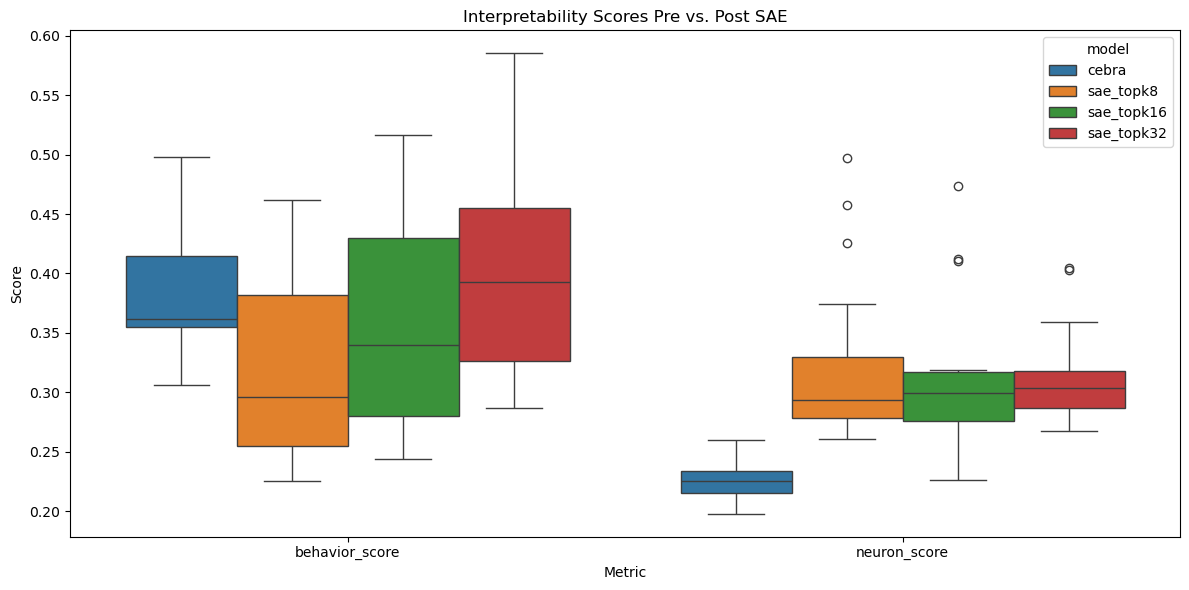

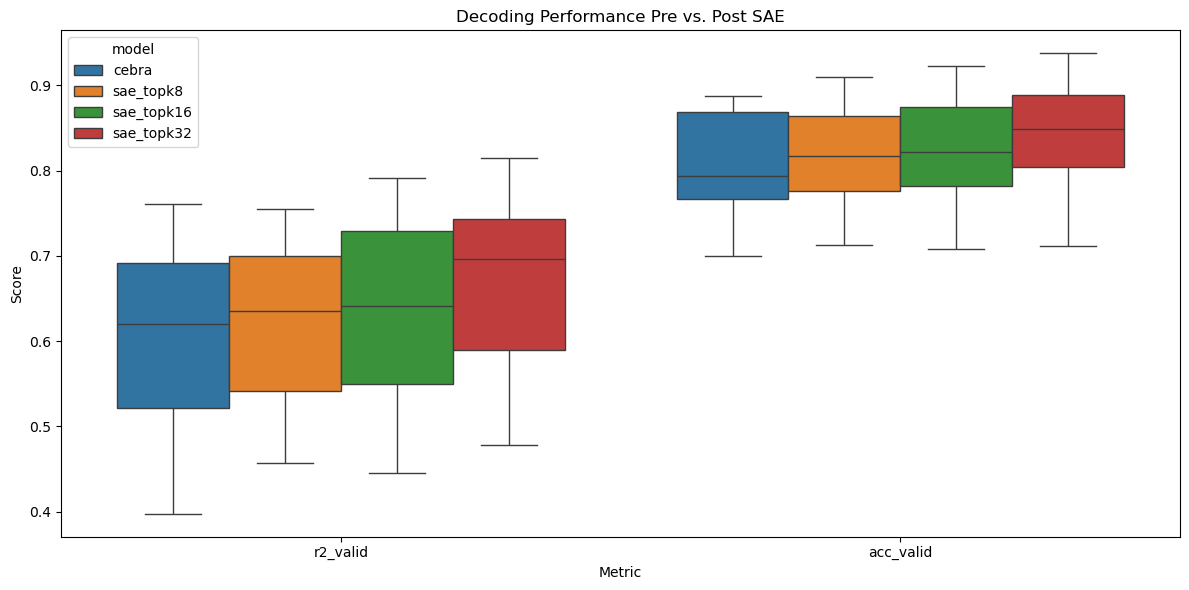

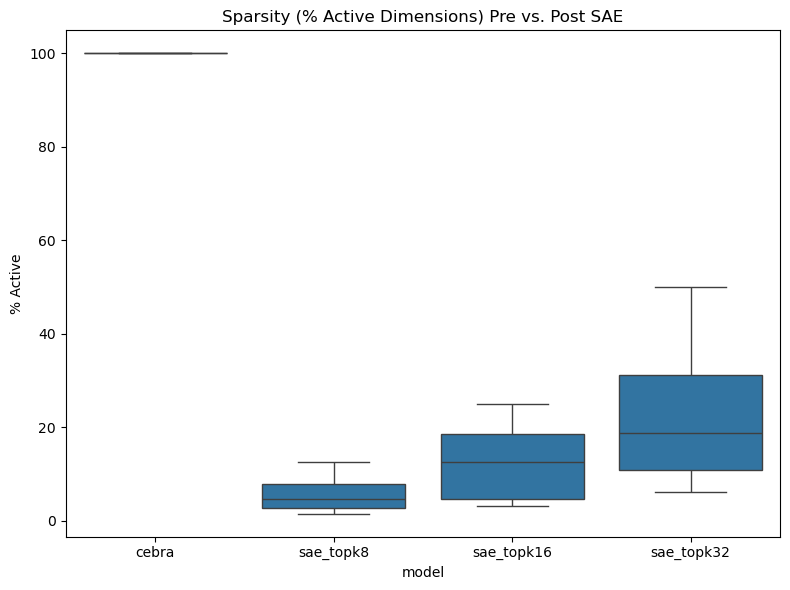

In [14]:
df = df_results.copy()
df['model'] = df.apply(
    lambda row: f"{row['model']}{int(row['topk'])}" if row['model'] == 'sae_topk' else row['model'],
    axis=1
)

melted = df.melt(
    id_vars=["rat", "dim", "topk", "model"],
    value_vars=["behavior_score", "neuron_score", "r2_valid", "acc_valid", "sparsity"],
    var_name="Metric",
    value_name="Value"
)


plt.figure(figsize=(12, 6))
sns.boxplot(data=melted[melted["Metric"].isin(["behavior_score", "neuron_score"])], x="Metric", y="Value", hue="model")
plt.title("Interpretability Scores Pre vs. Post SAE")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

# Plot decoding performance
plt.figure(figsize=(12, 6))
sns.boxplot(data=melted[melted["Metric"].isin(["r2_valid", "acc_valid"])], x="Metric", y="Value", hue="model")
plt.title("Decoding Performance Pre vs. Post SAE")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

# Plot sparsity change
plt.figure(figsize=(8, 6))
sns.boxplot(data=melted[melted["Metric"] == "sparsity"], x="model", y="Value")
plt.title("Sparsity (% Active Dimensions) Pre vs. Post SAE")
plt.ylabel("% Active")
plt.tight_layout()
plt.show()


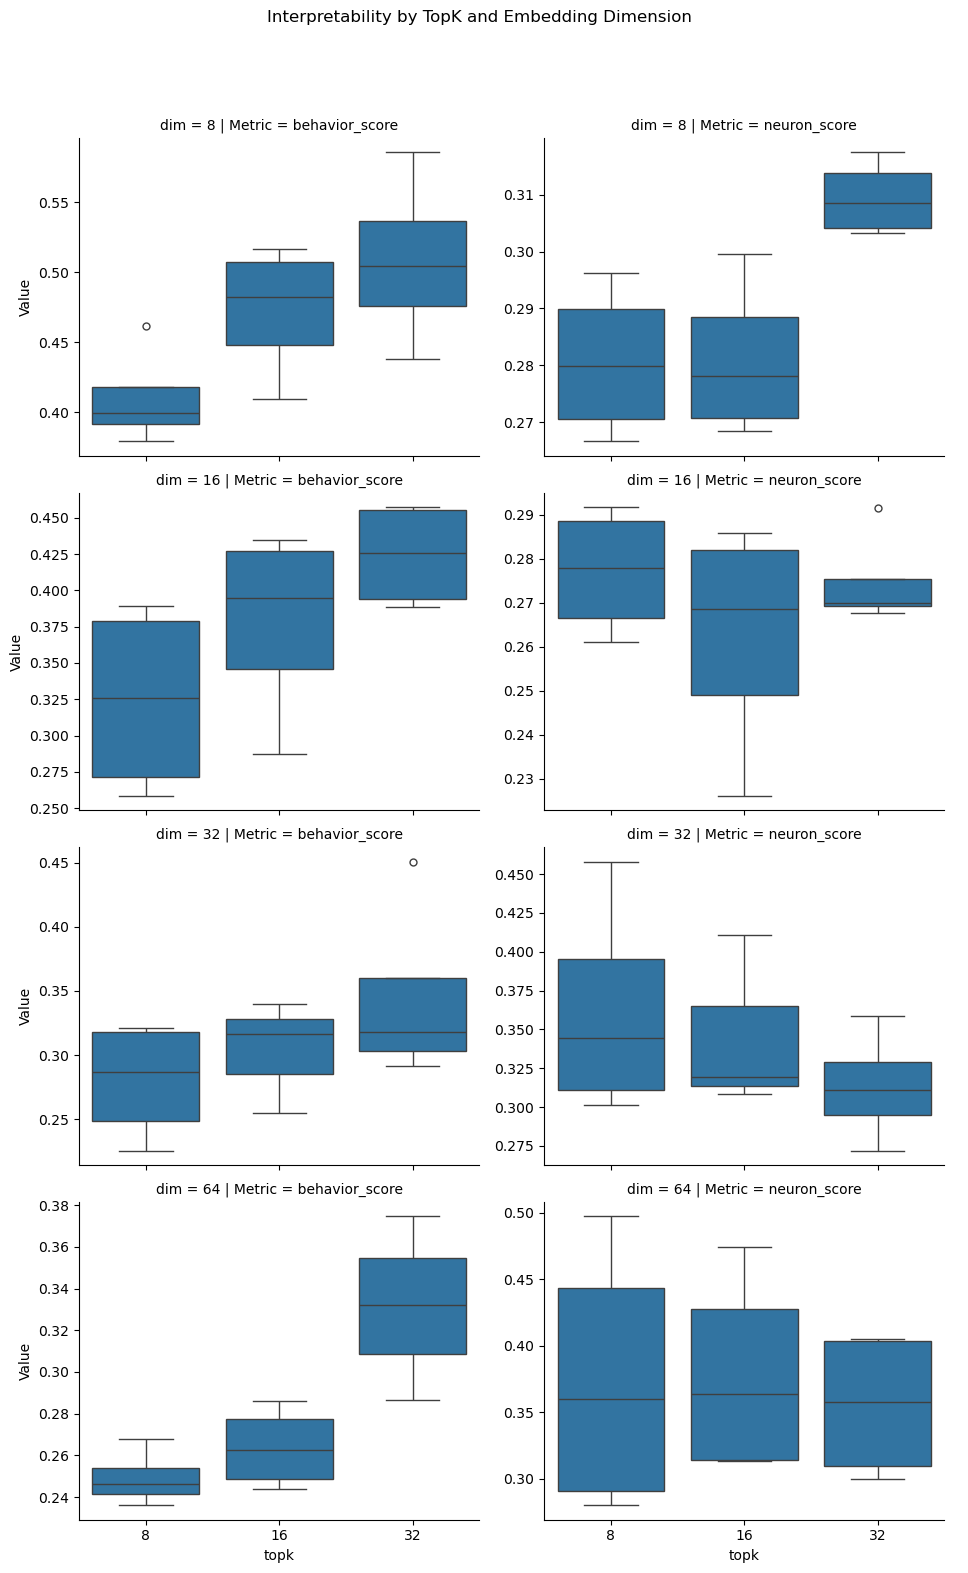

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Only post-SAE results with valid topk values
post_sae = melted[(melted["model"] != "cebra") & (~melted["topk"].isna())]
post_sae["topk"] = post_sae["topk"].astype(int)

# Interpretability scores
g = sns.catplot(
    data=post_sae[post_sae["Metric"].isin(["behavior_score", "neuron_score"])],
    x="topk",
    y="Value",
    col="Metric",
    row="dim",
    kind="box",
    height=4,
    aspect=1.2,
    sharey=False
)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Interpretability by TopK and Embedding Dimension")
plt.show()


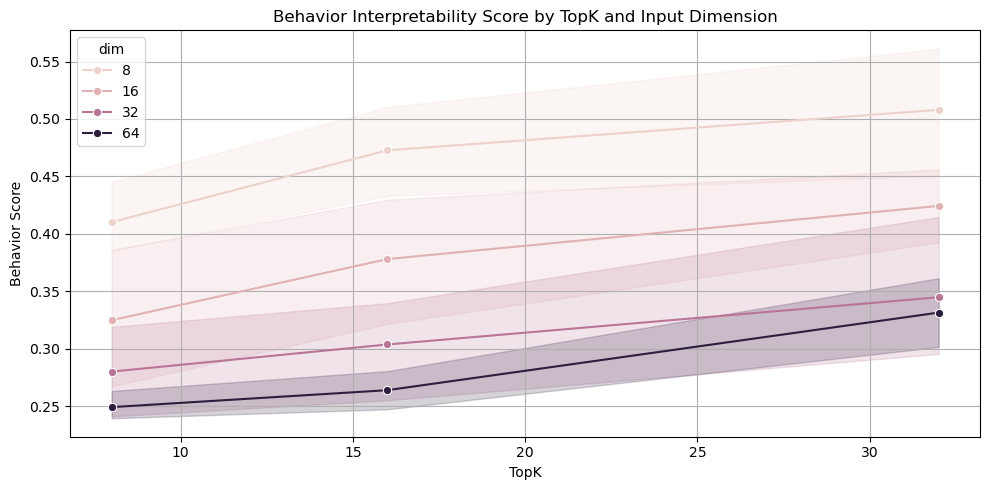

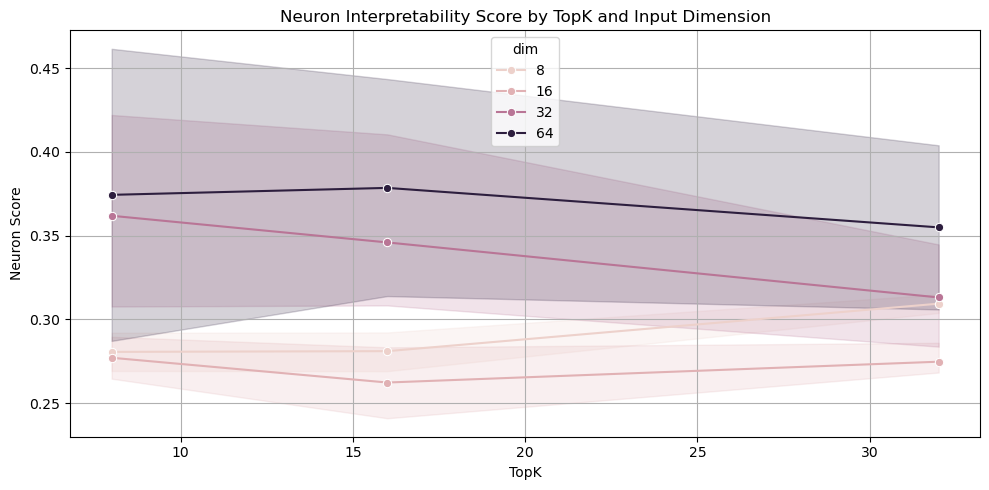

In [16]:
df_sae = df_results[df_results["topk"].notna()]  # Only post-SAE

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_sae, x="topk", y="behavior_score", hue="dim", marker="o")
plt.title("Behavior Interpretability Score by TopK and Input Dimension")
plt.xlabel("TopK")
plt.ylabel("Behavior Score")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_sae, x="topk", y="neuron_score", hue="dim", marker="o")
plt.title("Neuron Interpretability Score by TopK and Input Dimension")
plt.xlabel("TopK")
plt.ylabel("Neuron Score")
plt.grid(True)
plt.tight_layout()
plt.show()

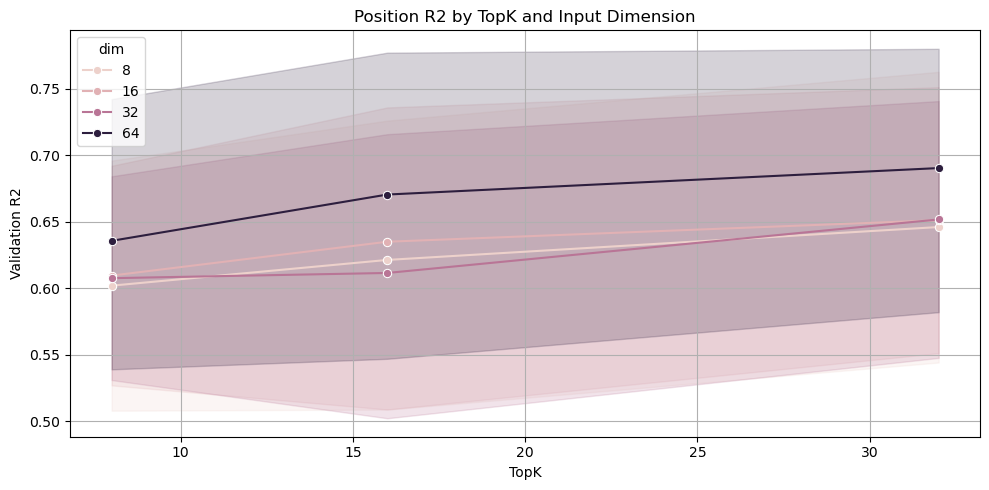

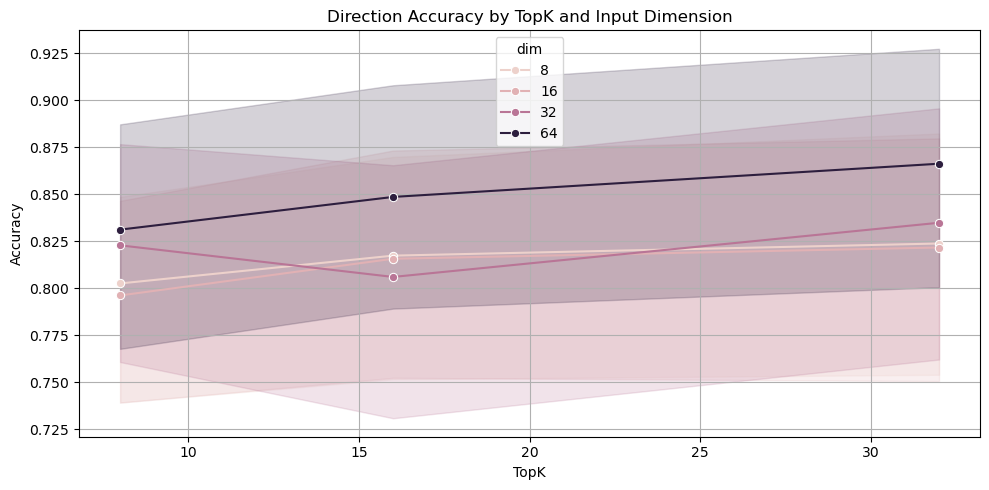

In [5]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_sae, x="topk", y="r2_valid", hue="dim", marker="o")
plt.title("Position R2 by TopK and Input Dimension")
plt.xlabel("TopK")
plt.ylabel("Validation R2")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_sae, x="topk", y="acc_valid", hue="dim", marker="o")
plt.title("Direction Accuracy by TopK and Input Dimension")
plt.xlabel("TopK")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

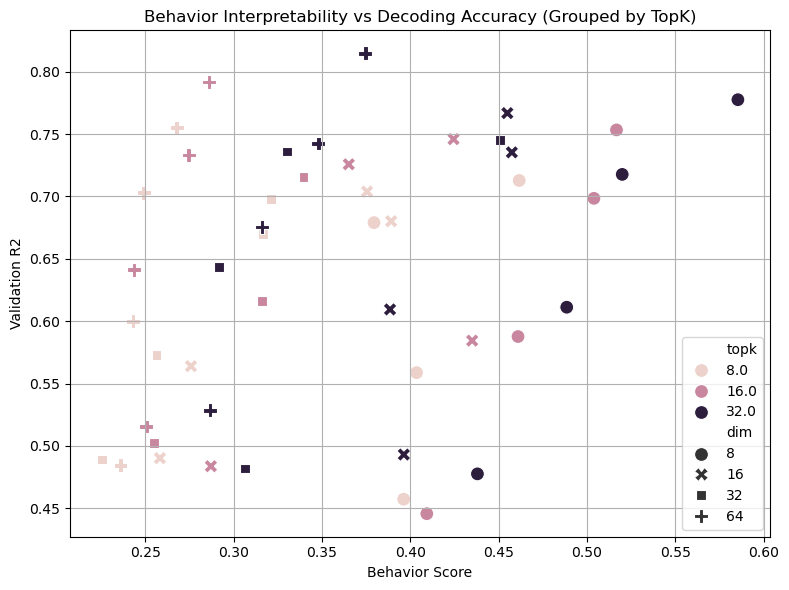

In [6]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_sae, x="behavior_score", y="r2_valid", hue="topk", style="dim", s=100)
plt.title("Behavior Interpretability vs Decoding Accuracy (Grouped by TopK)")
plt.xlabel("Behavior Score")
plt.ylabel("Validation R2")
plt.grid(True)
plt.tight_layout()
plt.show()
